# Utilizando o módulo ThermDiff

Solução dos problemas de difusão térmica em um meio quiescente unidimensional.

$$\frac{\partial T}{\partial t} = \alpha \frac{\partial ^2 T}{\partial x^2}$$

Novidades com relação ao problema anterior:

 - Operador differencial assimétrico
 - Uso de condições de contorno
 - Esquemas compactos com integradores implícitos

**Integradores implementados:**
 - Euler explícito
 - MacCormack
 - RK4
 - Lax-Wendroff
 - Euler implícito
 - Trapezoidal
 - ABM3

In [33]:
# coding = utf-8
import time
import ThermDiff as TD
import numpy as np
import matplotlib.pyplot as pp

## Condições de contorno:
  - Parede isotérmica:
  ```T = TD.isotermica(T0,dx,dt,nt,nc,integrador)```
  - Parede adiabática:
  ```T = TD.adiabatica(T0,dx,dt,nt,nc,integrador)```

## Estrutura do módulo:

 * Diff2Schemes: Segunda derivada por diferenças finitas;
 * DiffSchemes: Primeira derivada por diferenças finitas (utilizado somente na integração Lax-Wendroff);
 * ADiffPoint: Operadores derivada assimétricos para condições de contorno de alta ordem;
 * DiffImp: Cálculo das matrizes para integração implícita, utiliza as bibliotecas BLAS e LAPACK.
  

## Matemática:

### Operadores diferenciais:

$$\beta\left(\left. \frac{\partial T}{\partial x}\right|_{i-2} + \left. \frac{\partial T}{\partial x}\right|_{i+2}\right) + \alpha\left(\left. \frac{\partial T}{\partial x}\right|_{i-1} + \left. \frac{\partial T}{\partial x}\right|_{i+1} \right) + \left. \frac{\partial T}{\partial x}\right|_{i} = a\frac{T_{i+1} - 2T_i + T_{i-1}}{\Delta x^2} + b\frac{T_{i+2} - 2T_i + T_{i-2}}{4\Delta x^2} + c\frac{T_{i+3} - 2T_i + T_{i-3}}{9\Delta x^2}$$


|Operador| a | b | c | $\alpha$ | $\beta$ |
|:-------|:-:|:-:|:-:|:-:|:-:|
|Center 2| 1 | 0 | 0 | 0 | 0 |
|Center 4|-5/2|4/3|-1/12| 0 | 0 |
|Thomas 4|4(1-$\alpha$)/3|(10$\alpha$-1)/3|0|1/10|0|
|Thomas 6|3/11|12/11|0|2/11|0|
|Thomas 8|(696-1191$\alpha$)/428|(2454$\alpha$-294)/535|0|344/1179|(38$\alpha$-9)/214|
|Thomas 10|1065/1798|1038/899|79/1798|334/899|43/1798|

### Operadores assimétricos

Implementados somente para cálculo da primeira derivada em um ponto específico.

#### Backward 3

$$\left. \frac{\partial f}{\partial x}\right|_i = \frac{-3f_i + 4f_{i-1} - f_{i-2}}{2\Delta x}$$

#### Forward 3

$$\left. \frac{\partial f}{\partial x}\right|_i = \frac{3f_i - 4f_{i+1} + f_{i+2}}{2\Delta x}$$

#### Backward 4

$$\left. \frac{\partial f}{\partial x}\right|_i = \frac{\frac{11}{6}f_i - 3f_{i-1} + \frac{3}{2}f_{i-2} - \frac{1}{3}f_{i-3}}{\Delta x}$$

#### Forward 4

$$\left. \frac{\partial f}{\partial x}\right|_i = \frac{-\frac{11}{6}f_i + 3f_{i+1} - \frac{3}{2}f_{i+2} + \frac{1}{3}f_{i+3}}{\Delta x}$$

#### Backward 2 + Forward 1

$$\left. \frac{\partial f}{\partial x}\right|_i = \frac{\frac{1}{3}f_{i+1} + \frac{1}{2}f_i - f_{i-1} + \frac{1}{6}f_{i-2}}{\Delta x}$$

#### Backward 1 + Forward 2

$$\left. \frac{\partial f}{\partial x}\right|_i = \frac{-\frac{1}{3}f_{i-1} - \frac{1}{2}f_i + f_{i+1} - \frac{1}{6}f_{i+2}}{\Delta x}$$

### Integradores

#### Euler explícito

$$ T_{i+1} = T_i + \Delta t \left.\frac{\partial T}{\partial t}\right|_i $$

#### MacCormack

$$ \tilde{T}_i = T_i + \Delta t \left.\frac{\partial T}{\partial t}\right|_i $$
$$ T_{i+1} = \frac{1}{2}\left(T_i + \tilde{T}_i + \Delta t\left.\frac{\partial T}{\partial t}\right|_i\right) $$

#### Runge-Kutta 4a

$$ \tilde{T}_i = T_i + \frac{1}{2}\Delta t \left.\frac{\partial T}{\partial t}\right|_i $$

$$ \bar{T}_i = T_i + \frac{1}{2}\Delta t \left.\frac{\partial \tilde{T}}{\partial t}\right|_i $$

$$ \hat{T}_i = T_i + \Delta t \left.\frac{\partial \bar{T}}{\partial t}\right|_i $$

$$ T_{i+1} = T_i + \Delta t \frac{1}{6}\left[\left.\frac{\partial T}{\partial t}\right|_i + 2\left(\left.\frac{\partial \tilde{T}}{\partial t}\right|_i + \left.\frac{\partial \bar{T}}{\partial t}\right|_i\right) + \left.\frac{\partial \hat{T}}{\partial t}\right|_i\right] $$

#### Lax-Wendroff

$$ T_{i+1} = T_i + \Delta t \left.\frac{\partial T}{\partial t}\right|_i + {\Delta t}^2 \left.\frac{\partial^2 T}{\partial t^2}\right|_i$$

#### Euler implícito

$$ T_{i+1} = T_i + \Delta t \left.\frac{\partial T}{\partial t}\right|_{i+1} $$

Na forma matricial:

$$ T_{i+1} = \left[1 - \Delta t \alpha \mathbf{A}\right]^{-1}T_i = \mathbf{C} T_i$$

Sendo $\mathbf{A}$ a matriz correspondente à operação de diferenciação. A matriz $\mathbf{C}$ é calculada pela função:

```
ProxDiff(C,k,dx,odf,n)
```

Sendo k a constante de integração, dx o espaçamento, odf a ordem da discretização e n a quantidade de nós.


#### Trapezoidal

$$ T_{i+1} = T_i + \frac{1}{2}\Delta t\left( \left.\frac{\partial T}{\partial t}\right|_{i+1} + \left.\frac{\partial T}{\partial t}\right|_{i} \right) $$

$$ T_{i+1} = \left[1 - \Delta t \alpha \mathbf{A}\right]^{-1}\left[1 + \Delta t \alpha \mathbf{A}\right]T_i = \mathbf{C} \mathbf{B}T_i$$

A matriz $\mathbf{B}$ é dada pela função:

```
AtualDiff(C,k,dx,odf,n)
```

#### Adam-Bashfort-Moulton 3

$$ T_{i+1} = T_i + \frac{1}{12}\Delta t\left( 5\left.\frac{\partial T}{\partial t}\right|_{i+1} + 8\left.\frac{\partial T}{\partial t}\right|_{i} - \left.\frac{\partial T}{\partial t}\right|_{i-1}\right) $$


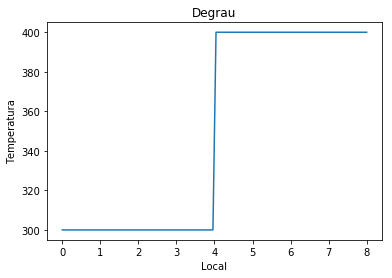

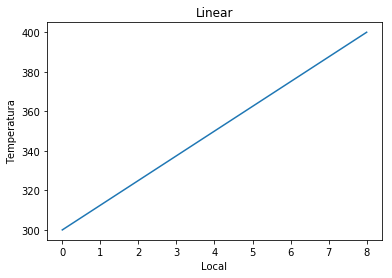

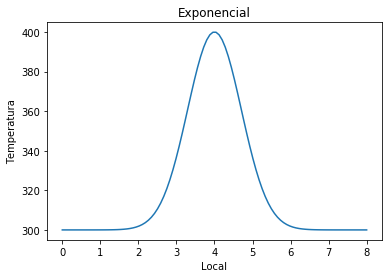

In [34]:
T1 = 300.; # Temperatura inicial 1
T2 = 400.; # Temperatura inicial 2
L = 8.;    # Comprimento do domínio
nc = 100;  # Número de nós
dx = L/nc;
tf = 4e-1;
dt = 5e-5;
nt = int(tf/dt);
Td = np.zeros((nc));
Te = np.zeros((nc));
Tl = np.zeros((nc));

l = np.linspace(0,L,nc);
t = np.linspace(0,tf,nt);

for i in range(0,nc/2):
    Td[i] = T1;
    Tl[i] = T1 + (T2-T1)*l[i]/L;
    Te[i] = T1 + (T2-T1)*np.exp(-(l[i]-L/2)**2);
for i in range(nc/2,nc):
    Td[i] = T2;
    Tl[i] = T1 + (T2-T1)*l[i]/L;
    Te[i] = T1 + (T2-T1)*np.exp(-(l[i]-L/2)**2);
# end

pp.figure()
pp.plot(l,Td)
pp.title('Degrau')
pp.ylabel('Temperatura')
pp.xlabel('Local')

pp.figure()
pp.plot(l,Tl)
pp.title('Linear')
pp.ylabel('Temperatura')
pp.xlabel('Local')

pp.figure()
pp.plot(l,Te)
pp.title('Exponencial')
pp.ylabel('Temperatura')
pp.xlabel('Local')

pp.show()

In [35]:
# Euler explícito com discretização centrada
integrador = 'B4222'
tic = time.clock();
T = TD.isotermica(Td,dx,dt,integrador,nt,nc)
toc = time.clock();
print('Tempo de processamento:',toc-tic,'s')

('Tempo de processamento:', 0.004519000000000162, 's')


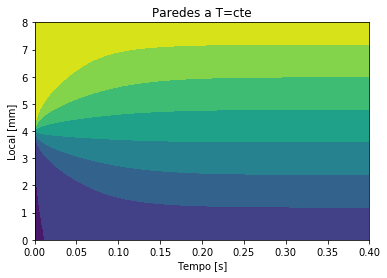

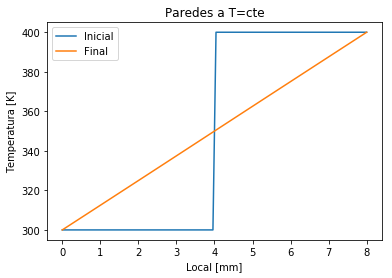

In [36]:
pp.figure()
pp.contourf(t, l, T)
pp.title('Paredes a T=cte')
pp.xlabel('Tempo [s]')
pp.ylabel('Local [mm]')

T0 = np.zeros((nc));
Tf = np.zeros((nc));

for i in range(0,nc):
    T0[i] = T[i,0];
    Tf[i] = T[i,nt-1];

pp.figure()
pp.plot(l,T0)
pp.plot(l,Tf)
pp.title('Paredes a T=cte')
pp.xlabel('Local [mm]')
pp.ylabel('Temperatura [K]')
pp.legend(['Inicial','Final'])
pp.show()

In [37]:
# MacCormack com discretização compacta
integrador = 'B8822'
tf = 0.1;
nt = int(tf/dt);
t = np.linspace(0,tf,nt);
tic = time.clock();
T = TD.isotermica(Te,dx,dt,integrador,nt,nc)
toc = time.clock();
print('Tempo de processamento:',toc-tic,'s')

('Tempo de processamento:', 0.007618000000000791, 's')


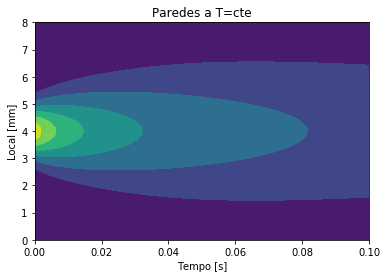

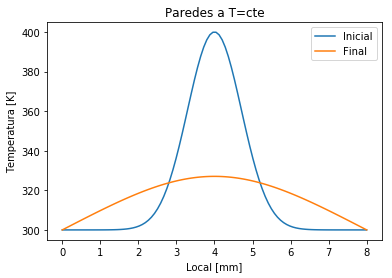

In [38]:
pp.figure()
pp.contourf(t, l, T)
pp.xlabel('Tempo [s]')
pp.ylabel('Local [mm]')
pp.title('Paredes a T=cte')

T0 = np.zeros((nc));
Tf = np.zeros((nc));

for i in range(0,nc):
    T0[i] = T[i,0];
    Tf[i] = T[i,nt-1];

pp.figure()
pp.plot(l,T0)
pp.plot(l,Tf)
pp.xlabel('Local [mm]')
pp.ylabel('Temperatura [K]')
pp.title('Paredes a T=cte')
pp.legend(['Inicial','Final'])
pp.show()

In [55]:
# Euler implícito com discretização centrada
integrador = 'E2222'
tf = 0.4;
nt = int(tf/dt);
t = np.linspace(0,tf,nt);
tic = time.clock();
T = TD.adiabatica(Tl,dx,dt,integrador,nt,nc)
toc = time.clock();
print('Tempo de processamento:',toc-tic,'s')

('Tempo de processamento:', 13.02052599999999, 's')


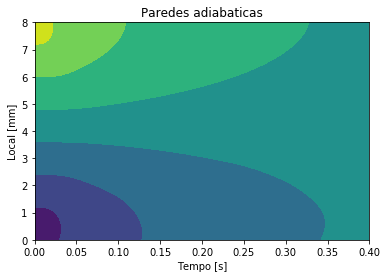

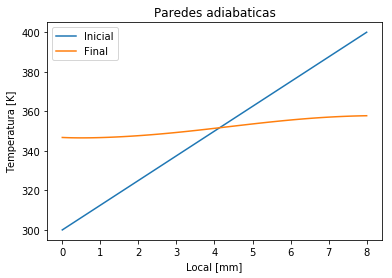

In [56]:
pp.figure()
pp.contourf(t, l, T)
pp.xlabel('Tempo [s]')
pp.ylabel('Local [mm]')
pp.title('Paredes adiabaticas')

T0 = np.zeros((nc));
Tf = np.zeros((nc));

for i in range(0,nc):
    T0[i] = T[i,0];
    Tf[i] = T[i,nt-1];

pp.figure()
pp.plot(l,T0)
pp.plot(l,Tf)
pp.xlabel('Local [mm]')
pp.ylabel('Temperatura [K]')
pp.title('Paredes adiabaticas')
pp.legend(['Inicial','Final'])
pp.show()

In [57]:
# Lax-Wendroff com discretização centrada
integrador = 'D2222'
tf = 0.5;
nt = int(tf/dt);
t = np.linspace(0,tf,nt);
tic = time.clock();
T = TD.adiabatica(Td,dx,dt,integrador,nt,nc)
toc = time.clock();
print('Tempo de processamento:',toc-tic,'s')

('Tempo de processamento:', 0.0046360000000049695, 's')


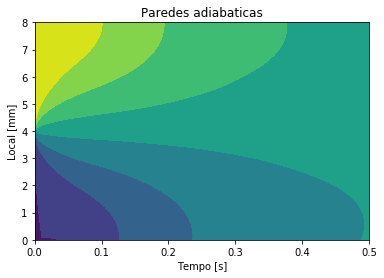

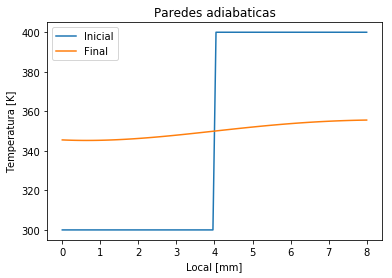

In [58]:
pp.figure()
pp.contourf(t, l, T)
pp.xlabel('Tempo [s]')
pp.ylabel('Local [mm]')
pp.title('Paredes adiabaticas')

T0 = np.zeros((nc));
Tf = np.zeros((nc));

for i in range(0,nc):
    T0[i] = T[i,0];
    Tf[i] = T[i,nt-1];

pp.figure()
pp.plot(l,T0)
pp.plot(l,Tf)
pp.xlabel('Local [mm]')
pp.ylabel('Temperatura [K]')
pp.title('Paredes adiabaticas')
pp.legend(['Inicial','Final'])
pp.show()

In [51]:
# Trapezoidal com discretização centrada
integrador = 'F2222'
tf = 0.1;
nt = int(tf/dt);
t = np.linspace(0,tf,nt);
tic = time.clock();
T = TD.adiabatica(Te,dx,dt,integrador,nt,nc)
toc = time.clock();
print('Tempo de processamento:',toc-tic,'s')

('Tempo de processamento:', 4.7384910000000104, 's')


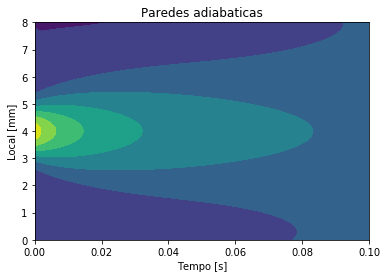

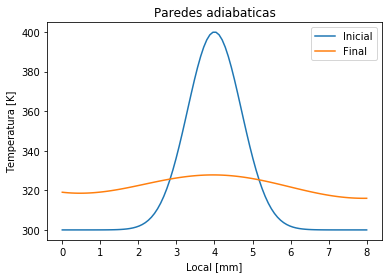

In [52]:
pp.figure()
pp.contourf(t, l, T)
pp.xlabel('Tempo [s]')
pp.ylabel('Local [mm]')
pp.title('Paredes adiabaticas')

T0 = np.zeros((nc));
Tf = np.zeros((nc));

for i in range(0,nc):
    T0[i] = T[i,0];
    Tf[i] = T[i,nt-1];

pp.figure()
pp.plot(l,T0)
pp.plot(l,Tf)
pp.xlabel('Local [mm]')
pp.ylabel('Temperatura [K]')
pp.title('Paredes adiabaticas')
pp.legend(['Inicial','Final'])
pp.show()